# Import libraries

In [1]:
import sys
sys.path.append(r'/home/gishb/PycharmProjects/MLTdataanalysis') 

import libs_cpd
from datareader.SythData import SythDataGenerator
from optimization.functions import cumsum, queue
import create_report

# Import data

In [2]:
small_noise = SythDataGenerator(10, 1000, 50)

In [3]:
data = small_noise.runner()

# Look at data

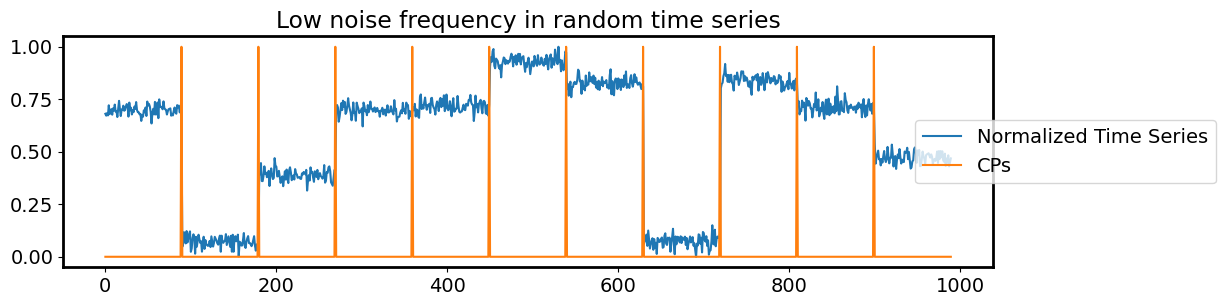

In [4]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(data[0], label='Normalized Time Series')
libs_cpd.plt.plot(data[1], label='CPs')
libs_cpd.plt.title('Low noise frequency in random time series')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

# Search for hyperparameters via WSS class

In [5]:
trajectory_window_length = 2*libs_cpd.WindowSizeSelection(time_series = data[0], wss_algorithm='summary_statistics_subsequence').runner_wss()[0]

In [6]:
print(trajectory_window_length)

92


In [7]:
ts_window_length = 2*int(libs_cpd.np.mean([libs_cpd.WindowSizeSelection(time_series = data[0][i:trajectory_window_length+i]).runner_wss()[0] for i in range(0, len(data[0])-trajectory_window_length, trajectory_window_length)]))

In [8]:
print(ts_window_length)

22


# Define SST model

Apply SST model -> apply CUMSUM -> apply queue filter -> get results

In [9]:
model = libs_cpd.SingularSpectrumTransformation(time_series=libs_cpd.np.array(data[0]), quantile_rate=0.95,
                                       trajectory_window_length=trajectory_window_length,
                                       ts_window_length=ts_window_length, lag=int(ts_window_length/2), view=False)

In [10]:
score = model.score_offline(dynamic_mode=True)
score = cumsum(score, quantile_=0.95)

In [11]:
predicted_cps = [1 if i in score[-2] else 0 for i in range(len(data[0]))]

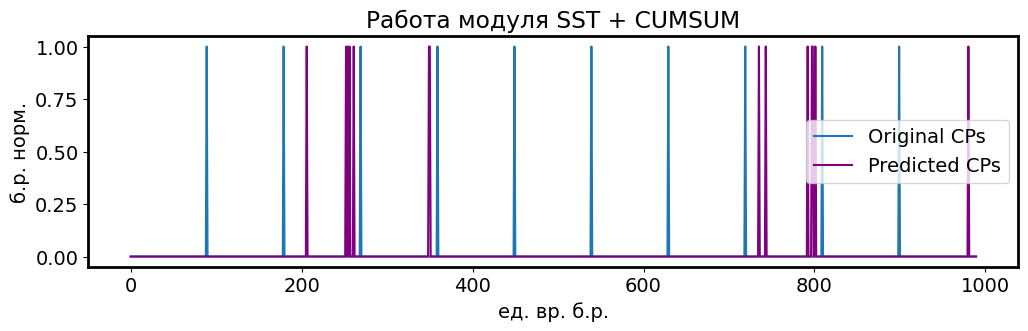

In [12]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(data[1], label='Original CPs')
libs_cpd.plt.plot(predicted_cps, label='Predicted CPs', color='Purple')
libs_cpd.plt.legend(loc="center right")
libs_cpd.plt.title('Работа модуля SST + CUMSUM')
libs_cpd.plt.xlabel('ед. вр. б.р.')
libs_cpd.plt.ylabel('б.р. норм.')
libs_cpd.plt.show()

In [13]:
queue_cps = queue(time_series=predicted_cps)

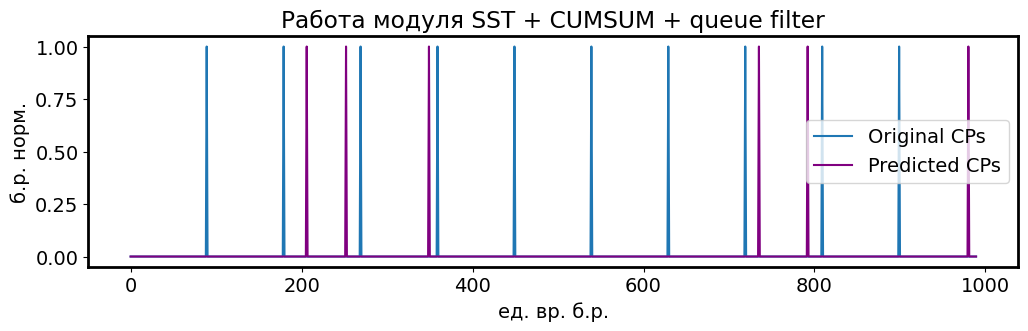

In [14]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(data[1], label='Original CPs')
libs_cpd.plt.plot(queue_cps, label='Predicted CPs', color='Purple')
libs_cpd.plt.legend(loc="center right")
libs_cpd.plt.title('Работа модуля SST + CUMSUM + queue filter')
libs_cpd.plt.xlabel('ед. вр. б.р.')
libs_cpd.plt.ylabel('б.р. норм.')
libs_cpd.plt.show()

# Create report

In [15]:
df = libs_cpd.pd.DataFrame()
df['origin_cps'] = data[1]
df['predicted_cps'] = queue_cps
df['time'] = libs_cpd.np.arange(0, len(df)*1, 1).astype('datetime64[s]')
df = df.set_index('time')

In [16]:
%%capture --no-display
tsad_average_results = create_report.tsad_average(df['predicted_cps'], df['origin_cps'])

In [17]:
%%capture --no-display
tsad_nab_results = create_report.tsad_nab(df['predicted_cps'], df['origin_cps'])

In [18]:
tsad_nab_results.update(tsad_average_results)
create_report.create_report(tsad_nab_results)

,0
Standart,19.82
LowFP,17.32
LowFN,23.21
Time_Delta,0 days 00:00:14.666666666
Missed_CP,7
FPs,3
True_Anomalies_Count,10
precision,0.5
recall,0.3
F1,0.375
